In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


matching the psg files to hypnograms by names

In [1]:
import os

edf_folder = r"E:\sleep_full_dataset"  # Change this to the correct folder path

# Get all files in the folder
all_files = os.listdir(edf_folder)

# Extract PSG and Hypnogram file lists
psg_files = [f for f in all_files if "-PSG.edf" in f]
hypnogram_files = [f for f in all_files if "-Hypnogram.edf" in f]

# Extract subject IDs using only the first 7 characters (e.g., "SC4022")
psg_subjects = {f[:7]: f for f in psg_files}
hypnogram_subjects = {f[:7]: f for f in hypnogram_files}

# Find matching PSG & Hypnogram pairs
matched_files = []
for subject_id, psg_file in psg_subjects.items():
    if subject_id in hypnogram_subjects:
        matched_files.append((psg_file, hypnogram_subjects[subject_id]))
    else:
        print(f"⚠️ Warning: Hypnogram file not found for {psg_file}")

# Print matched PSG-Hypnogram pairs
for psg, hypnogram in matched_files:
    print(f"✅ Matched: {psg} <-> {hypnogram}")

⚠️ Warning: Hypnogram file not found for SC4801G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4802G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4812G0-PSG.edf
⚠️ Warning: Hypnogram file not found for ST7242J0-PSG.edf
✅ Matched: SC4092E0-PSG.edf <-> SC4092EC-Hypnogram.edf
✅ Matched: SC4101E0-PSG.edf <-> SC4101EC-Hypnogram.edf
✅ Matched: SC4102E0-PSG.edf <-> SC4102EC-Hypnogram.edf
✅ Matched: SC4111E0-PSG.edf <-> SC4111EC-Hypnogram.edf
✅ Matched: SC4112E0-PSG.edf <-> SC4112EC-Hypnogram.edf
✅ Matched: SC4121E0-PSG.edf <-> SC4121EC-Hypnogram.edf
✅ Matched: SC4122E0-PSG.edf <-> SC4122EV-Hypnogram.edf
✅ Matched: SC4131E0-PSG.edf <-> SC4131EC-Hypnogram.edf
✅ Matched: SC4141E0-PSG.edf <-> SC4141EU-Hypnogram.edf
✅ Matched: SC4142E0-PSG.edf <-> SC4142EU-Hypnogram.edf
✅ Matched: SC4151E0-PSG.edf <-> SC4151EC-Hypnogram.edf
✅ Matched: SC4152E0-PSG.edf <-> SC4152EC-Hypnogram.edf
✅ Matched: SC4161E0-PSG.edf <-> SC4161EC-Hypnogram.edf
✅ Matched: SC4162E0-PSG.edf <-> SC4162EC-Hypnogram.ed

processing into 3o sec window, and mounting the hypnogram files

In [2]:
import os
import numpy as np
import pyedflib
from tqdm import tqdm

edf_folder = r"E:\sleep_full_dataset"
output_folder = "processed_epochs"
os.makedirs(output_folder, exist_ok=True)

# Required EEG channels
required_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

# Function to extract sleep stage labels from hypnogram
def extract_labels(hypnogram_file):
    edf_reader = pyedflib.EdfReader(hypnogram_file)
    annotations = edf_reader.readAnnotations()
    edf_reader.close()
    
    onset_times = annotations[0]  # Start time of annotation
    durations = annotations[1]    # Duration of annotation
    labels = annotations[2]       # Sleep stage labels

    sleep_stages = []
    for onset, duration, label in zip(onset_times, durations, labels):
        epoch_count = int(duration // 30)  # Number of 30-sec epochs
        sleep_stages.extend([label] * epoch_count)

    return np.array(sleep_stages)

# Process each matched PSG-Hypnogram pair
for psg_file, hypnogram_file in tqdm(matched_files, desc="Processing EEG Data"):
    psg_path = os.path.join(edf_folder, psg_file)
    hypnogram_path = os.path.join(edf_folder, hypnogram_file)

    # Load EEG data from PSG file
    edf_reader = pyedflib.EdfReader(psg_path)
    channel_labels = edf_reader.getSignalLabels()

    # Find indices of required channels
    channel_indices = [channel_labels.index(ch) for ch in required_channels if ch in channel_labels]
    if not channel_indices:
        print(f"Skipping {psg_file}: Required EEG channels not found!")
        edf_reader.close()
        continue

    # Extract EEG signals
    eeg_signals = np.array([edf_reader.readSignal(idx) for idx in channel_indices])
    sampling_rate = edf_reader.getSampleFrequencies()[channel_indices[0]]
    edf_reader.close()

    # Calculate number of samples per 30s epoch
    samples_per_epoch = int(sampling_rate * 30)
    num_epochs = eeg_signals.shape[1] // samples_per_epoch  # Number of full epochs

    # Trim EEG signals to full epochs only
    eeg_epochs = eeg_signals[:, :num_epochs * samples_per_epoch].reshape(num_epochs, len(channel_indices), samples_per_epoch)

    # Extract sleep stage labels
    sleep_labels = extract_labels(hypnogram_path)

    # Ensure sleep labels match the number of epochs
    min_epochs = min(num_epochs, len(sleep_labels))
    eeg_epochs = eeg_epochs[:min_epochs]
    sleep_labels = sleep_labels[:min_epochs]

    # Save processed epochs
    save_path = os.path.join(output_folder, psg_file.replace("-PSG.edf", ".npz"))
    np.savez(save_path, eeg=eeg_epochs, labels=sleep_labels, fs=sampling_rate, channels=required_channels)

    print(f"Processed and saved: {psg_file}")

print("✅ EEG epochs successfully processed and saved with corresponding labels.")

Processing EEG Data:   1%|          | 1/122 [00:02<04:20,  2.15s/it]

Processed and saved: SC4092E0-PSG.edf


Processing EEG Data:   2%|▏         | 2/122 [00:08<09:01,  4.51s/it]

Processed and saved: SC4101E0-PSG.edf


Processing EEG Data:   2%|▏         | 3/122 [00:13<09:51,  4.97s/it]

Processed and saved: SC4102E0-PSG.edf


Processing EEG Data:   3%|▎         | 4/122 [00:15<07:28,  3.80s/it]

Processed and saved: SC4111E0-PSG.edf


Processing EEG Data:   4%|▍         | 5/122 [00:18<06:41,  3.43s/it]

Processed and saved: SC4112E0-PSG.edf


Processing EEG Data:   5%|▍         | 6/122 [00:20<05:45,  2.98s/it]

Processed and saved: SC4121E0-PSG.edf


Processing EEG Data:   6%|▌         | 7/122 [00:22<05:03,  2.64s/it]

Processed and saved: SC4122E0-PSG.edf


Processing EEG Data:   7%|▋         | 8/122 [00:25<04:50,  2.55s/it]

Processed and saved: SC4131E0-PSG.edf


Processing EEG Data:   7%|▋         | 9/122 [00:27<04:30,  2.40s/it]

Processed and saved: SC4141E0-PSG.edf


Processing EEG Data:   8%|▊         | 10/122 [00:29<04:16,  2.29s/it]

Processed and saved: SC4142E0-PSG.edf


Processing EEG Data:   9%|▉         | 11/122 [00:31<04:03,  2.19s/it]

Processed and saved: SC4151E0-PSG.edf


Processing EEG Data:  10%|▉         | 12/122 [00:33<03:59,  2.18s/it]

Processed and saved: SC4152E0-PSG.edf


Processing EEG Data:  11%|█         | 13/122 [00:35<03:55,  2.16s/it]

Processed and saved: SC4161E0-PSG.edf


Processing EEG Data:  11%|█▏        | 14/122 [00:37<03:57,  2.20s/it]

Processed and saved: SC4162E0-PSG.edf


Processing EEG Data:  12%|█▏        | 15/122 [00:40<04:21,  2.44s/it]

Processed and saved: SC4171E0-PSG.edf


Processing EEG Data:  13%|█▎        | 16/122 [00:42<04:08,  2.35s/it]

Processed and saved: SC4172E0-PSG.edf


Processing EEG Data:  14%|█▍        | 17/122 [00:44<03:57,  2.26s/it]

Processed and saved: SC4181E0-PSG.edf


Processing EEG Data:  15%|█▍        | 18/122 [00:46<03:51,  2.22s/it]

Processed and saved: SC4182E0-PSG.edf


Processing EEG Data:  16%|█▌        | 19/122 [00:49<04:13,  2.46s/it]

Processed and saved: SC4191E0-PSG.edf


Processing EEG Data:  16%|█▋        | 20/122 [00:51<03:56,  2.32s/it]

Processed and saved: SC4192E0-PSG.edf


Processing EEG Data:  17%|█▋        | 21/122 [00:54<03:52,  2.31s/it]

Processed and saved: SC4201E0-PSG.edf


Processing EEG Data:  18%|█▊        | 22/122 [00:56<03:43,  2.23s/it]

Processed and saved: SC4202E0-PSG.edf


Processing EEG Data:  19%|█▉        | 23/122 [00:58<03:38,  2.21s/it]

Processed and saved: SC4211E0-PSG.edf


Processing EEG Data:  20%|█▉        | 24/122 [01:01<03:55,  2.40s/it]

Processed and saved: SC4212E0-PSG.edf


Processing EEG Data:  20%|██        | 25/122 [01:03<03:51,  2.38s/it]

Processed and saved: SC4221E0-PSG.edf


Processing EEG Data:  21%|██▏       | 26/122 [01:05<03:37,  2.27s/it]

Processed and saved: SC4222E0-PSG.edf


Processing EEG Data:  22%|██▏       | 27/122 [01:08<03:54,  2.47s/it]

Processed and saved: SC4231E0-PSG.edf


Processing EEG Data:  23%|██▎       | 28/122 [01:10<03:38,  2.33s/it]

Processed and saved: SC4232E0-PSG.edf


Processing EEG Data:  24%|██▍       | 29/122 [01:12<03:27,  2.23s/it]

Processed and saved: SC4241E0-PSG.edf


Processing EEG Data:  25%|██▍       | 30/122 [01:14<03:20,  2.18s/it]

Processed and saved: SC4242E0-PSG.edf


Processing EEG Data:  25%|██▌       | 31/122 [01:16<03:19,  2.20s/it]

Processed and saved: SC4251E0-PSG.edf


Processing EEG Data:  26%|██▌       | 32/122 [01:19<03:31,  2.35s/it]

Processed and saved: SC4252E0-PSG.edf


Processing EEG Data:  27%|██▋       | 33/122 [01:21<03:21,  2.26s/it]

Processed and saved: SC4261F0-PSG.edf


Processing EEG Data:  28%|██▊       | 34/122 [01:23<03:12,  2.18s/it]

Processed and saved: SC4262F0-PSG.edf


Processing EEG Data:  29%|██▊       | 35/122 [01:25<03:00,  2.07s/it]

Processed and saved: SC4271F0-PSG.edf


Processing EEG Data:  30%|██▉       | 36/122 [01:27<02:59,  2.09s/it]

Processed and saved: SC4272F0-PSG.edf


Processing EEG Data:  30%|███       | 37/122 [01:29<02:56,  2.08s/it]

Processed and saved: SC4281G0-PSG.edf


Processing EEG Data:  31%|███       | 38/122 [01:32<03:08,  2.24s/it]

Processed and saved: SC4282G0-PSG.edf


Processing EEG Data:  32%|███▏      | 39/122 [01:34<03:01,  2.19s/it]

Processed and saved: SC4291G0-PSG.edf


Processing EEG Data:  33%|███▎      | 40/122 [01:36<02:57,  2.16s/it]

Processed and saved: SC4292G0-PSG.edf


Processing EEG Data:  34%|███▎      | 41/122 [01:38<02:51,  2.11s/it]

Processed and saved: SC4311E0-PSG.edf


Processing EEG Data:  34%|███▍      | 42/122 [01:41<03:12,  2.40s/it]

Processed and saved: SC4312E0-PSG.edf


Processing EEG Data:  35%|███▌      | 43/122 [01:43<03:04,  2.33s/it]

Processed and saved: SC4321E0-PSG.edf


Processing EEG Data:  36%|███▌      | 44/122 [01:46<03:12,  2.47s/it]

Processed and saved: SC4331F0-PSG.edf


Processing EEG Data:  37%|███▋      | 45/122 [01:48<03:00,  2.35s/it]

Processed and saved: SC4332F0-PSG.edf


Processing EEG Data:  38%|███▊      | 46/122 [01:50<02:52,  2.27s/it]

Processed and saved: SC4341F0-PSG.edf


Processing EEG Data:  39%|███▊      | 47/122 [01:52<02:45,  2.21s/it]

Processed and saved: SC4342F0-PSG.edf


Processing EEG Data:  39%|███▉      | 48/122 [01:54<02:38,  2.15s/it]

Processed and saved: SC4351F0-PSG.edf


Processing EEG Data:  40%|████      | 49/122 [01:56<02:31,  2.08s/it]

Processed and saved: SC4352F0-PSG.edf


Processing EEG Data:  41%|████      | 50/122 [01:58<02:22,  1.98s/it]

Processed and saved: SC4362F0-PSG.edf


Processing EEG Data:  42%|████▏     | 51/122 [02:00<02:25,  2.05s/it]

Processed and saved: SC4371F0-PSG.edf


Processing EEG Data:  43%|████▎     | 52/122 [02:03<02:40,  2.30s/it]

Processed and saved: SC4372F0-PSG.edf


Processing EEG Data:  43%|████▎     | 53/122 [02:05<02:33,  2.22s/it]

Processed and saved: SC4381F0-PSG.edf


Processing EEG Data:  44%|████▍     | 54/122 [02:07<02:27,  2.17s/it]

Processed and saved: SC4382F0-PSG.edf


Processing EEG Data:  45%|████▌     | 55/122 [02:09<02:21,  2.11s/it]

Processed and saved: SC4401E0-PSG.edf


Processing EEG Data:  46%|████▌     | 56/122 [02:12<02:28,  2.25s/it]

Processed and saved: SC4402E0-PSG.edf


Processing EEG Data:  47%|████▋     | 57/122 [02:14<02:22,  2.19s/it]

Processed and saved: SC4411E0-PSG.edf


Processing EEG Data:  48%|████▊     | 58/122 [02:16<02:19,  2.19s/it]

Processed and saved: SC4412E0-PSG.edf


Processing EEG Data:  48%|████▊     | 59/122 [02:18<02:18,  2.20s/it]

Processed and saved: SC4421E0-PSG.edf


Processing EEG Data:  49%|████▉     | 60/122 [02:20<02:12,  2.14s/it]

Processed and saved: SC4422E0-PSG.edf


Processing EEG Data:  50%|█████     | 61/122 [02:22<02:10,  2.14s/it]

Processed and saved: SC4431E0-PSG.edf


Processing EEG Data:  51%|█████     | 62/122 [02:24<02:08,  2.14s/it]

Processed and saved: SC4432E0-PSG.edf


Processing EEG Data:  52%|█████▏    | 63/122 [02:27<02:18,  2.36s/it]

Processed and saved: SC4441E0-PSG.edf


Processing EEG Data:  52%|█████▏    | 64/122 [02:30<02:18,  2.39s/it]

Processed and saved: SC4442E0-PSG.edf


Processing EEG Data:  53%|█████▎    | 65/122 [02:32<02:11,  2.31s/it]

Processed and saved: SC4451F0-PSG.edf


Processing EEG Data:  54%|█████▍    | 66/122 [02:34<02:07,  2.27s/it]

Processed and saved: SC4452F0-PSG.edf


Processing EEG Data:  55%|█████▍    | 67/122 [02:36<02:01,  2.20s/it]

Processed and saved: SC4461F0-PSG.edf


Processing EEG Data:  56%|█████▌    | 68/122 [02:38<01:58,  2.19s/it]

Processed and saved: SC4462F0-PSG.edf


Processing EEG Data:  57%|█████▋    | 69/122 [02:40<01:53,  2.15s/it]

Processed and saved: SC4471F0-PSG.edf


Processing EEG Data:  57%|█████▋    | 70/122 [02:43<02:01,  2.35s/it]

Processed and saved: SC4472F0-PSG.edf


Processing EEG Data:  58%|█████▊    | 71/122 [02:46<02:08,  2.51s/it]

Processed and saved: SC4481F0-PSG.edf


Processing EEG Data:  59%|█████▉    | 72/122 [02:48<02:04,  2.49s/it]

Processed and saved: SC4482F0-PSG.edf


Processing EEG Data:  60%|█████▉    | 73/122 [02:51<02:02,  2.50s/it]

Processed and saved: SC4491G0-PSG.edf


Processing EEG Data:  61%|██████    | 74/122 [02:53<01:48,  2.25s/it]

Processed and saved: SC4492G0-PSG.edf


Processing EEG Data:  61%|██████▏   | 75/122 [02:55<01:45,  2.24s/it]

Processed and saved: SC4501E0-PSG.edf


Processing EEG Data:  62%|██████▏   | 76/122 [02:57<01:43,  2.26s/it]

Processed and saved: SC4502E0-PSG.edf


Processing EEG Data:  63%|██████▎   | 77/122 [02:59<01:39,  2.20s/it]

Processed and saved: SC4511E0-PSG.edf


Processing EEG Data:  64%|██████▍   | 78/122 [03:01<01:38,  2.25s/it]

Processed and saved: SC4512E0-PSG.edf


Processing EEG Data:  65%|██████▍   | 79/122 [03:04<01:38,  2.29s/it]

Processed and saved: SC4522E0-PSG.edf


Processing EEG Data:  66%|██████▌   | 80/122 [03:06<01:33,  2.23s/it]

Processed and saved: SC4531E0-PSG.edf


Processing EEG Data:  66%|██████▋   | 81/122 [03:09<01:35,  2.33s/it]

Processed and saved: SC4532E0-PSG.edf


Processing EEG Data:  67%|██████▋   | 82/122 [03:11<01:30,  2.25s/it]

Processed and saved: SC4541F0-PSG.edf


Processing EEG Data:  68%|██████▊   | 83/122 [03:13<01:31,  2.34s/it]

Processed and saved: SC4542F0-PSG.edf


Processing EEG Data:  69%|██████▉   | 84/122 [03:15<01:27,  2.29s/it]

Processed and saved: SC4551F0-PSG.edf


Processing EEG Data:  70%|██████▉   | 85/122 [03:17<01:23,  2.25s/it]

Processed and saved: SC4552F0-PSG.edf


Processing EEG Data:  70%|███████   | 86/122 [03:20<01:18,  2.19s/it]

Processed and saved: SC4561F0-PSG.edf


Processing EEG Data:  71%|███████▏  | 87/122 [03:22<01:16,  2.17s/it]

Processed and saved: SC4562F0-PSG.edf


Processing EEG Data:  72%|███████▏  | 88/122 [03:24<01:20,  2.36s/it]

Processed and saved: SC4571F0-PSG.edf


Processing EEG Data:  73%|███████▎  | 89/122 [03:27<01:23,  2.54s/it]

Processed and saved: SC4572F0-PSG.edf


Processing EEG Data:  74%|███████▍  | 90/122 [03:30<01:24,  2.65s/it]

Processed and saved: SC4581G0-PSG.edf


Processing EEG Data:  75%|███████▍  | 91/122 [03:32<01:16,  2.46s/it]

Processed and saved: SC4582G0-PSG.edf


Processing EEG Data:  75%|███████▌  | 92/122 [03:35<01:11,  2.39s/it]

Processed and saved: SC4591G0-PSG.edf


Processing EEG Data:  76%|███████▌  | 93/122 [03:36<01:02,  2.15s/it]

Processed and saved: SC4592G0-PSG.edf


Processing EEG Data:  77%|███████▋  | 94/122 [03:38<00:59,  2.14s/it]

Processed and saved: SC4601E0-PSG.edf


Processing EEG Data:  78%|███████▊  | 95/122 [03:40<00:57,  2.14s/it]

Processed and saved: SC4602E0-PSG.edf


Processing EEG Data:  79%|███████▊  | 96/122 [03:42<00:54,  2.11s/it]

Processed and saved: SC4611E0-PSG.edf


Processing EEG Data:  80%|███████▉  | 97/122 [03:45<00:58,  2.35s/it]

Processed and saved: SC4612E0-PSG.edf


Processing EEG Data:  80%|████████  | 98/122 [03:47<00:53,  2.24s/it]

Processed and saved: SC4621E0-PSG.edf


Processing EEG Data:  81%|████████  | 99/122 [03:50<00:51,  2.22s/it]

Processed and saved: SC4622E0-PSG.edf


Processing EEG Data:  82%|████████▏ | 100/122 [03:52<00:48,  2.19s/it]

Processed and saved: SC4631E0-PSG.edf


Processing EEG Data:  83%|████████▎ | 101/122 [03:54<00:46,  2.19s/it]

Processed and saved: SC4632E0-PSG.edf


Processing EEG Data:  84%|████████▎ | 102/122 [03:56<00:43,  2.15s/it]

Processed and saved: SC4641E0-PSG.edf


Processing EEG Data:  84%|████████▍ | 103/122 [03:58<00:41,  2.16s/it]

Processed and saved: SC4651E0-PSG.edf


Processing EEG Data:  85%|████████▌ | 104/122 [04:00<00:38,  2.16s/it]

Processed and saved: SC4652E0-PSG.edf


Processing EEG Data:  86%|████████▌ | 105/122 [04:02<00:36,  2.13s/it]

Processed and saved: SC4661E0-PSG.edf


Processing EEG Data:  87%|████████▋ | 106/122 [04:04<00:34,  2.13s/it]

Processed and saved: SC4662E0-PSG.edf


Processing EEG Data:  88%|████████▊ | 107/122 [04:07<00:31,  2.13s/it]

Processed and saved: SC4671G0-PSG.edf


Processing EEG Data:  89%|████████▊ | 108/122 [04:09<00:29,  2.08s/it]

Processed and saved: SC4672G0-PSG.edf


Processing EEG Data:  89%|████████▉ | 109/122 [04:11<00:26,  2.07s/it]

Processed and saved: SC4701E0-PSG.edf


Processing EEG Data:  90%|█████████ | 110/122 [04:13<00:24,  2.08s/it]

Processed and saved: SC4702E0-PSG.edf


Processing EEG Data:  91%|█████████ | 111/122 [04:15<00:22,  2.07s/it]

Processed and saved: SC4711E0-PSG.edf


Processing EEG Data:  92%|█████████▏| 112/122 [04:17<00:22,  2.27s/it]

Processed and saved: SC4712E0-PSG.edf


Processing EEG Data:  93%|█████████▎| 113/122 [04:19<00:19,  2.12s/it]

Processed and saved: SC4721E0-PSG.edf


Processing EEG Data:  93%|█████████▎| 114/122 [04:21<00:16,  2.11s/it]

Processed and saved: SC4722E0-PSG.edf


Processing EEG Data:  94%|█████████▍| 115/122 [04:23<00:14,  2.11s/it]

Processed and saved: SC4731E0-PSG.edf


Processing EEG Data:  95%|█████████▌| 116/122 [04:25<00:12,  2.06s/it]

Processed and saved: SC4732E0-PSG.edf


Processing EEG Data:  96%|█████████▌| 117/122 [04:27<00:10,  2.07s/it]

Processed and saved: SC4751E0-PSG.edf


Processing EEG Data:  97%|█████████▋| 118/122 [04:29<00:08,  2.02s/it]

Processed and saved: SC4811G0-PSG.edf


Processing EEG Data:  98%|█████████▊| 119/122 [04:32<00:06,  2.14s/it]

Processed and saved: SC4821G0-PSG.edf


Processing EEG Data:  98%|█████████▊| 120/122 [04:34<00:04,  2.14s/it]

Processed and saved: SC4822G0-PSG.edf


Processing EEG Data:  99%|█████████▉| 121/122 [04:36<00:02,  2.18s/it]

Processed and saved: ST7222J0-PSG.edf


Processing EEG Data: 100%|██████████| 122/122 [04:39<00:00,  2.29s/it]

Processed and saved: ST7241J0-PSG.edf
✅ EEG epochs successfully processed and saved with corresponding labels.


In [21]:
import os
import numpy as np
import scipy.signal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Path to processed EEG epochs
data_folder = "processed_epochs"

def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)
    psd = np.log1p(psd)
    return psd.flatten()

X, y = [], []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]
        labels = data["labels"]
        fs = data["fs"]

        for i in range(eeg_epochs.shape[0]):
            features = np.hstack([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

X, y = np.array(X), np.array(y)

if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class EEGClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x  # No softmax because CrossEntropyLoss applies it

num_classes = len(np.unique(y))
model = EEGClassifier(input_size=X_train.shape[1], num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_true, y_pred))

Epoch 1/30, Loss: 1.0216
Epoch 2/30, Loss: 0.9925
Epoch 3/30, Loss: 0.9788
Epoch 4/30, Loss: 0.9687
Epoch 5/30, Loss: 0.9608
Epoch 6/30, Loss: 0.9538
Epoch 7/30, Loss: 0.9483
Epoch 8/30, Loss: 0.9435
Epoch 9/30, Loss: 0.9399
Epoch 10/30, Loss: 0.9359
Epoch 11/30, Loss: 0.9331
Epoch 12/30, Loss: 0.9297
Epoch 13/30, Loss: 0.9259
Epoch 14/30, Loss: 0.9234
Epoch 15/30, Loss: 0.9211
Epoch 16/30, Loss: 0.9196
Epoch 17/30, Loss: 0.9172
Epoch 18/30, Loss: 0.9146
Epoch 19/30, Loss: 0.9120
Epoch 20/30, Loss: 0.9108
Epoch 21/30, Loss: 0.9088
Epoch 22/30, Loss: 0.9069
Epoch 23/30, Loss: 0.9058
Epoch 24/30, Loss: 0.9038
Epoch 25/30, Loss: 0.9033
Epoch 26/30, Loss: 0.9023
Epoch 27/30, Loss: 0.9006
Epoch 28/30, Loss: 0.8990
Epoch 29/30, Loss: 0.8984
Epoch 30/30, Loss: 0.8957
Test Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.30      0.01      0.01      3708
           2       0.4

c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/30], Loss: 2.0842, Val Accuracy: 0.0102
Epoch [10/30], Loss: 2.0746, Val Accuracy: 0.3401
Epoch [15/30], Loss: 2.0549, Val Accuracy: 0.6554
Epoch [20/30], Loss: 2.0059, Val Accuracy: 0.6680
Epoch [25/30], Loss: 1.8958, Val Accuracy: 0.6680
Epoch [30/30], Loss: 1.7532, Val Accuracy: 0.6680
Test Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00      3708
           2       0.00      0.00      0.00     12067
           3       0.00      0.00      0.00      1562
           4       0.00      0.00      0.00       703
           5       0.00      0.00      0.00       236
           6       0.00      0.00      0.00      4539
           7       0.67      1.00      0.80     45954

    accuracy                           0.67     68790
   macro avg       0.08      0.12      0.10     68790
weighted avg       0.45      0.67      0.54     68790



c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


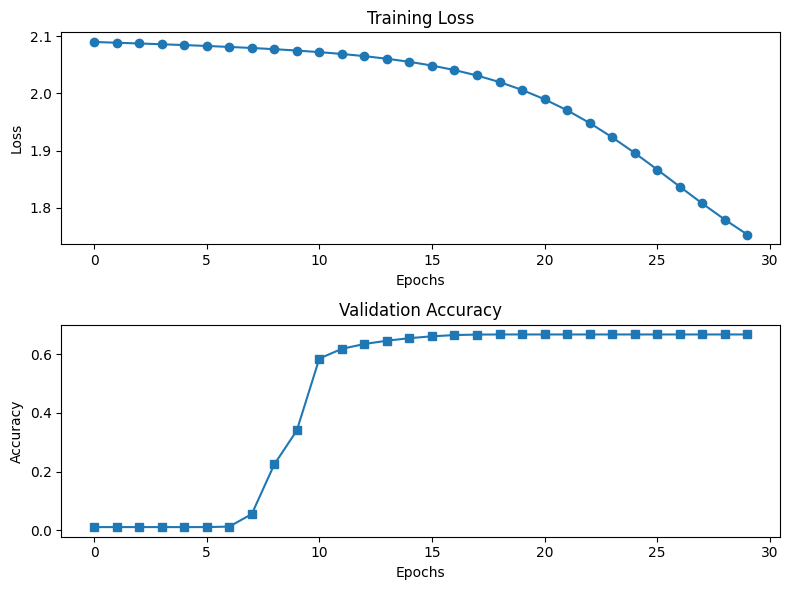

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
import scipy.signal

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  
    psd = np.log1p(psd)  # Log transform to avoid log(0) issues
    return psd.flatten()

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  # Shape: (num_epochs, num_channels, samples_per_epoch)
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_samples, num_channels, num_features)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define LSTM Model in PyTorch
class EEG_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(EEG_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size_1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size_1, hidden_size_2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size_2, 32)
        self.fc2 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.relu(x[:, -1, :])  # Use the output from the last time step
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize model
model = EEG_LSTM_Model(input_size=X_train.shape[2], hidden_size_1=128, hidden_size_2=64, output_size=len(np.unique(y)))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluate the model on validation set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / y_test.size(0)
        val_accuracies.append(accuracy)

    if (epoch + 1) % 5 == 0:  # Print every 5 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Accuracy: {accuracy:.4f}")

# Evaluate model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, predicted))

# Plot Training Loss and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(2, 1, 2)
plt.plot(val_accuracies, label='Val Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.tight_layout()
plt.show()


LSTM WITH regularization

c:\my_new_environment\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch [1/50], Loss: 2.2348, Train Accuracy: 0.0539, Test Accuracy: 0.1102
Epoch [2/50], Loss: 2.2199, Train Accuracy: 0.0737, Test Accuracy: 0.1158
Epoch [3/50], Loss: 2.2052, Train Accuracy: 0.0943, Test Accuracy: 0.1208
Epoch [4/50], Loss: 2.1905, Train Accuracy: 0.1158, Test Accuracy: 0.1281
Epoch [5/50], Loss: 2.1759, Train Accuracy: 0.1331, Test Accuracy: 0.1392
Epoch [6/50], Loss: 2.1608, Train Accuracy: 0.1468, Test Accuracy: 0.1456
Epoch [7/50], Loss: 2.1456, Train Accuracy: 0.1570, Test Accuracy: 0.1513
Epoch [8/50], Loss: 2.1301, Train Accuracy: 0.1633, Test Accuracy: 0.1584
Epoch [9/50], Loss: 2.1137, Train Accuracy: 0.1685, Test Accuracy: 0.1707
Epoch [10/50], Loss: 2.0971, Train Accuracy: 0.1712, Test Accuracy: 0.1753
Epoch [11/50], Loss: 2.0794, Train Accuracy: 0.1734, Test Accuracy: 0.1754
Epoch [12/50], Loss: 2.0609, Train Accuracy: 0.1767, Test Accuracy: 0.1754
Epoch [13/50], Loss: 2.0414, Train Accuracy: 0.1836, Test Accuracy: 0.1754
Epoch [14/50], Loss: 2.0207, Train

c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


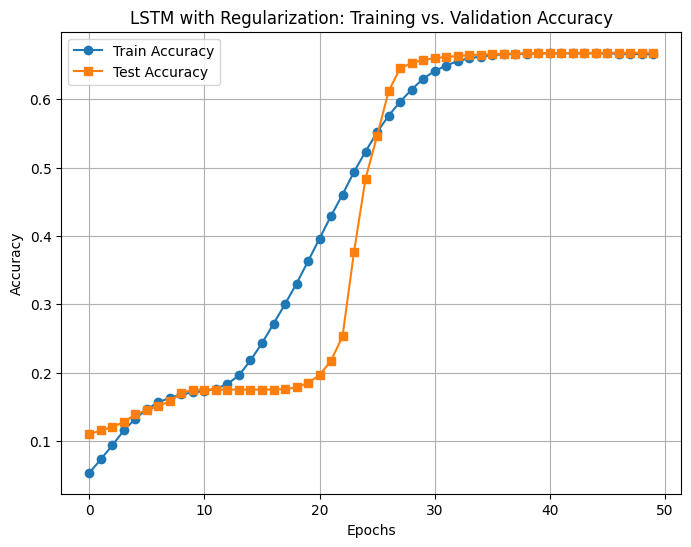

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
import scipy.signal

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  
    psd = np.log1p(psd)  # Log transform to avoid log(0) issues
    return psd.flatten()

# Load and preprocess data
X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  # Shape: (num_epochs, num_channels, samples_per_epoch)
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define LSTM Model with Regularization
class EEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = EEGModel(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate train accuracy
    _, predicted = torch.max(output, 1)
    train_accuracy = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        _, test_predicted = torch.max(test_output, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Evaluate final model
model.eval()
with torch.no_grad():
    final_test_output = model(X_test_tensor)
    _, final_test_predicted = torch.max(final_test_output, 1)
    accuracy = accuracy_score(y_test, final_test_predicted.numpy())
    print(f"Final Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, final_test_predicted.numpy()))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with Regularization: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


LSTM with dwt features


In [3]:
import numpy as np
import pywt
import os
import scipy.signal
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define LSTM Model with Regularization
class EEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = EEGModel(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate train accuracy
    _, predicted = torch.max(output, 1)
    train_accuracy = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        _, test_predicted = torch.max(test_output, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_test_output = model(X_test_tensor)
    _, final_test_predicted = torch.max(final_test_output, 1)
    accuracy = accuracy_score(y_test, final_test_predicted.numpy())
    print(f"Final Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, final_test_predicted.numpy()))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with DWT Features: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


MemoryError: Unable to allocate 12.3 GiB for an array with shape (275159, 2, 3006) and data type float64

after gpu optimization

c:\my_new_environment\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch [1/30], Loss: 2.2188, Train Accuracy: 0.0015, Test Accuracy: 0.0008
Epoch [2/30], Loss: 2.2062, Train Accuracy: 0.0014, Test Accuracy: 0.0008
Epoch [3/30], Loss: 2.1939, Train Accuracy: 0.0016, Test Accuracy: 0.0008
Epoch [4/30], Loss: 2.1819, Train Accuracy: 0.0017, Test Accuracy: 0.0008
Epoch [5/30], Loss: 2.1696, Train Accuracy: 0.0021, Test Accuracy: 0.0008
Epoch [6/30], Loss: 2.1574, Train Accuracy: 0.0020, Test Accuracy: 0.0008
Epoch [7/30], Loss: 2.1452, Train Accuracy: 0.0021, Test Accuracy: 0.0008
Epoch [8/30], Loss: 2.1327, Train Accuracy: 0.0025, Test Accuracy: 0.0008
Epoch [9/30], Loss: 2.1196, Train Accuracy: 0.0029, Test Accuracy: 0.0009
Epoch [10/30], Loss: 2.1066, Train Accuracy: 0.0038, Test Accuracy: 0.0009
Epoch [11/30], Loss: 2.0923, Train Accuracy: 0.0087, Test Accuracy: 0.0009
Epoch [12/30], Loss: 2.0780, Train Accuracy: 0.0232, Test Accuracy: 0.0014
Epoch [13/30], Loss: 2.0628, Train Accuracy: 0.0601, Test Accuracy: 0.0023
Epoch [14/30], Loss: 2.0467, Train

c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


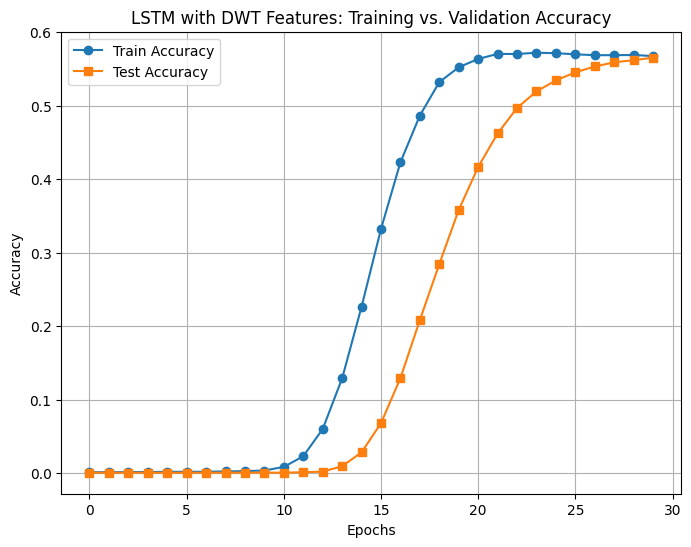

In [3]:
import numpy as np
import pywt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Set the number of CPU threads (limit to 30)
torch.set_num_threads(30)

# Check if GPU is available, and move the model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM Model with Regularization
class EEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = EEGModel(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
model.to(device)  # Move the model to GPU (if available)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Move data to device (GPU or CPU)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    
    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate train accuracy
    _, predicted = torch.max(output, 1)
    train_accuracy = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        test_output = model(X_test_tensor)
        _, test_predicted = torch.max(test_output, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_test_output = model(X_test_tensor.to(device))
    _, final_test_predicted = torch.max(final_test_output, 1)
    accuracy = accuracy_score(y_test, final_test_predicted.cpu().numpy())
    print(f"Final Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, final_test_predicted.cpu().numpy()))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with DWT Features: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


SleepEDFmodel

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pywt
import os

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

# Load EEG data
X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the SleepEEGModel with LSTM in PyTorch
class SleepEEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SleepEEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[2]  # Number of features per sample
num_classes = len(np.unique(y))
model = SleepEEGModel(input_size=input_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 30
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Compute train accuracy
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train_tensor, predicted)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor)
        loss_val = criterion(outputs_val, y_test_tensor)
        val_losses.append(loss_val.item())
        
        # Compute test accuracy
        _, predicted_val = torch.max(outputs_val, 1)
        val_accuracy = accuracy_score(y_test_tensor, predicted_val)
        val_accuracies.append(val_accuracy)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Evaluate model
print("\nFinal Evaluation:")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {val_accuracies[-1]:.4f}")
print("Classification Report (Test Set):\n", classification_report(y_test, predicted_val))

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy (LSTM Model)')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss (LSTM Model)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pywt
import os

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

# Load EEG data
X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Flatten for PCA
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the SleepEEGModel with LSTM in PyTorch
class SleepEEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SleepEEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x, _ = self.lstm2(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
input_size = X_train_pca.shape[1]  # Number of features after PCA
num_classes = len(np.unique(y))
model = SleepEEGModel(input_size=input_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 30
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor.unsqueeze(1))  # Add batch dimension for LSTM
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Compute train accuracy
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train_tensor, predicted)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor.unsqueeze(1))  # Add batch dimension for LSTM
        loss_val = criterion(outputs_val, y_test_tensor)
        val_losses.append(loss_val.item())
        
        # Compute test accuracy
        _, predicted_val = torch.max(outputs_val, 1)
        val_accuracy = accuracy_score(y_test_tensor, predicted_val)
        val_accuracies.append(val_accuracy)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Evaluate model
print("\nFinal Evaluation:")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {val_accuracies[-1]:.4f}")
print("Classification Report (Test Set):\n", classification_report(y_test, predicted_val))

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import os

# Ensure PyTorch Uses GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load EEG data
X = np.random.randn(1000, 32, 300)  # (Samples, Channels, Time)
y = np.random.randint(0, 5, 1000)   # 5 classes

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Apply PCA (Flatten first)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

# Convert to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ✅ Fixed LSTM Model
class SleepEEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SleepEEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take last time step
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model and move to GPU
input_size = X_train_pca.shape[1]
num_classes = len(np.unique(y))
model = SleepEEGModel(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor.unsqueeze(1))  # Add batch dimension for LSTM
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    # Compute training accuracy
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted.cpu())
    train_accuracies.append(train_accuracy)
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor.unsqueeze(1))  # Add batch dimension for LSTM
        loss_val = criterion(outputs_val, y_test_tensor)

        # Compute validation accuracy
        _, predicted_val = torch.max(outputs_val, 1)
        val_accuracy = accuracy_score(y_test_tensor.cpu(), predicted_val.cpu())
        val_accuracies.append(val_accuracy)
        val_losses.append(loss_val.item())
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {loss_val.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Final Evaluation
print("\nFinal Evaluation:")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {val_accuracies[-1]:.4f}")
print("Classification Report (Test Set):\n", classification_report(y_test, predicted_val))

# Plot Training and Validation Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()


Using device: cuda


c:\my_new_environment\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch [1/30], Train Loss: 1.6165, Train Accuracy: 0.1963, Val Loss: 1.6190, Val Accuracy: 0.1950
Epoch [2/30], Train Loss: 1.6115, Train Accuracy: 0.1963, Val Loss: 1.6187, Val Accuracy: 0.1950
Epoch [3/30], Train Loss: 1.6075, Train Accuracy: 0.1963, Val Loss: 1.6184, Val Accuracy: 0.1950
Epoch [4/30], Train Loss: 1.6038, Train Accuracy: 0.1963, Val Loss: 1.6182, Val Accuracy: 0.1950
Epoch [5/30], Train Loss: 1.5976, Train Accuracy: 0.1963, Val Loss: 1.6180, Val Accuracy: 0.1950
Epoch [6/30], Train Loss: 1.5958, Train Accuracy: 0.1975, Val Loss: 1.6178, Val Accuracy: 0.1950
Epoch [7/30], Train Loss: 1.5925, Train Accuracy: 0.1963, Val Loss: 1.6176, Val Accuracy: 0.1950
Epoch [8/30], Train Loss: 1.5883, Train Accuracy: 0.2025, Val Loss: 1.6174, Val Accuracy: 0.1950
Epoch [9/30], Train Loss: 1.5853, Train Accuracy: 0.2013, Val Loss: 1.6173, Val Accuracy: 0.1950
Epoch [10/30], Train Loss: 1.5815, Train Accuracy: 0.2050, Val Loss: 1.6172, Val Accuracy: 0.1950
Epoch [11/30], Train Loss: 1.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


Final Evaluation:
Final Train Accuracy: 0.6100
Final Test Accuracy: 0.1800
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.19      0.87      0.31        39
           1       0.00      0.00      0.00        37
           2       0.11      0.02      0.04        41
           3       0.00      0.00      0.00        41
           4       0.12      0.02      0.04        42

    accuracy                           0.18       200
   macro avg       0.08      0.18      0.08       200
weighted avg       0.09      0.18      0.08       200



c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


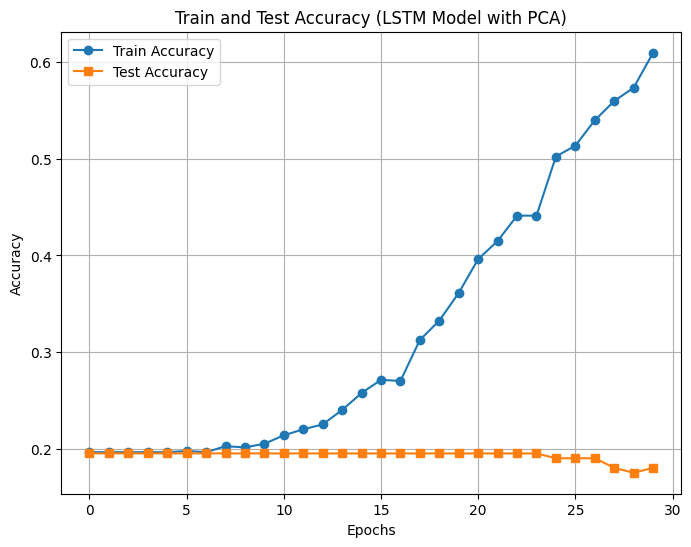

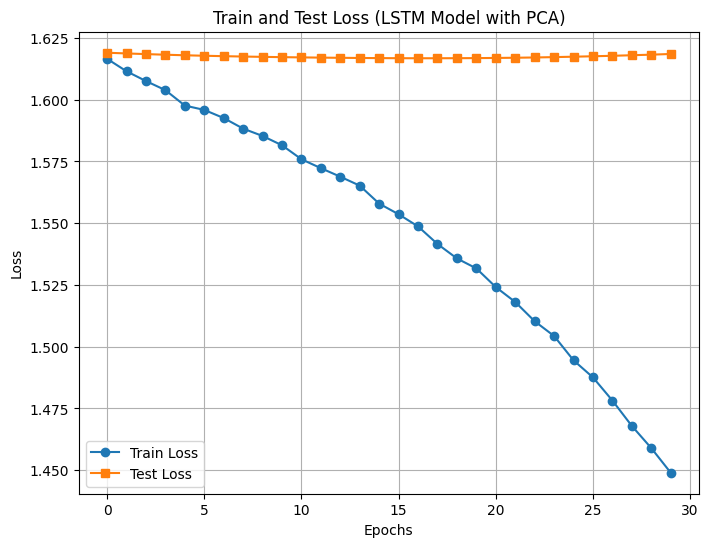

In [2]:
# Final Evaluation
print("\nFinal Evaluation:")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {val_accuracies[-1]:.4f}")

# Convert tensors to CPU and NumPy arrays before using classification_report
y_test_cpu = y_test_tensor.cpu().numpy()
predicted_val_cpu = predicted_val.cpu().numpy()

# Print classification report for the test set
print("Classification Report (Test Set):\n", classification_report(y_test_cpu, predicted_val_cpu))

# Plot Training and Validation Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss (LSTM Model with PCA)')
plt.legend()
plt.grid()
plt.show()
